# Transfer learning with Data Augmentation

This notebook focuses on building a deep learning model to classify images of cats and dogs. The dataset used consists of labeled images of cats and dogs, and the goal is to train a Convolutional Neural Network (CNN) to accurately distinguish between the two classes. The notebook is structured into several sections, each addressing a specific part of the machine learning workflow.


## Key Takeaways

- The notebook provides a step-by-step guide to building and training a CNN model for binary image classification (cats vs. dogs).
- It emphasizes the importance of data preprocessing, data augmentation, and model architecture design in achieving good performance.
- The use of visualization techniques and callbacks enhances the understanding of the training process and model performance.

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d salader/dogs-vs-cats

Dataset URL: https://www.kaggle.com/datasets/salader/dogs-vs-cats
License(s): unknown
100% 1.06G/1.06G [00:08<00:00, 212MB/s]
100% 1.06G/1.06G [00:08<00:00, 143MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/dogs-vs-cats.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import tensorflow
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Flatten
from keras.applications.vgg16 import VGG16
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

# Model Description

The model is built using **Transfer Learning** with the **VGG16** architecture as its base. The VGG16 model is pre-trained on the ImageNet dataset, and its convolutional layers are used as a feature extractor. On top of this, custom layers are added to adapt the model for the binary classification task (cats vs. dogs).

## Model Architecture

1. **VGG16 Base (Convolutional Base)**:
   - The `conv_base` is an instance of the VGG16 model with the following configurations:
     - `weights='imagenet'`: Loads pre-trained weights from the ImageNet dataset.
     - `include_top=False`: Excludes the fully connected layers at the top of the VGG16 model.
     - `input_shape=(150, 150, 3)`: Specifies the input image size as 150x150 pixels with 3 color channels (RGB).

2. **Custom Layers**:
   - **Flatten Layer**:
     - Flattens the output from the VGG16 base into a 1D vector to prepare it for fully connected layers.
   - **Dense Layer (256 units, ReLU activation)**:
     - A fully connected layer with 256 units and ReLU activation to learn complex patterns from the extracted features.
   - **Output Layer (1 unit, Sigmoid activation)**:
     - A single-unit dense layer with a sigmoid activation function for binary classification (cat or dog).


In [ ]:
conv_base = VGG16(
    weights='imagenet',
    include_top = False,
    input_shape=(150,150,3)
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model = Sequential()

model.add(conv_base)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [ ]:
conv_base.trainable = False

## **Loading and Preprocessing Data**:  **DATA AUGMENTATION**
- The dataset containing cat and dog images is loaded and preprocessed. This includes resizing the images to a consistent dimension, normalizing pixel values, and splitting the data into training and validation sets. Data augmentation techniques (e.g., rotation, flipping, zooming) are also applied to improve the model's generalization.

In [ ]:
batch_size = 32

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        '/content/train',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        '/content/test',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [ ]:
# Learning rate scheduler and early stopping
lr_scheduler = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)

In [ ]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
history = model.fit(train_generator,
                    epochs=100,batch_size=32,validation_data=validation_generator,
                    callbacks=[lr_scheduler, early_stopping, checkpoint])

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.8273 - loss: 0.4333
Epoch 1: val_accuracy improved from -inf to 0.91000, saving model to best_model.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 161s 239ms/step - accuracy: 0.8274 - loss: 0.4331 - val_accuracy: 0.9100 - val_loss: 0.2129 - learning_rate: 0.0010
Epoch 2/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.8940 - loss: 0.2459
Epoch 2: val_accuracy did not improve from 0.91000
625/625 ━━━━━━━━━━━━━━━━━━━━ 146s 231ms/step - accuracy: 0.8940 - loss: 0.2459 - val_accuracy: 0.9028 - val_loss: 0.2237 - learning_rate: 0.0010
Epoch 3/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.9024 - loss: 0.2301
Epoch 3: val_accuracy improved from 0.91000 to 0.91420, saving model to best_model.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 146s 231ms/step - accuracy: 0.9025 - loss: 0.2301 - val_accuracy: 0.9142 - val_loss: 0.2008 - learning_rate: 0.0010
Epoch 4/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.9129 - loss: 0.

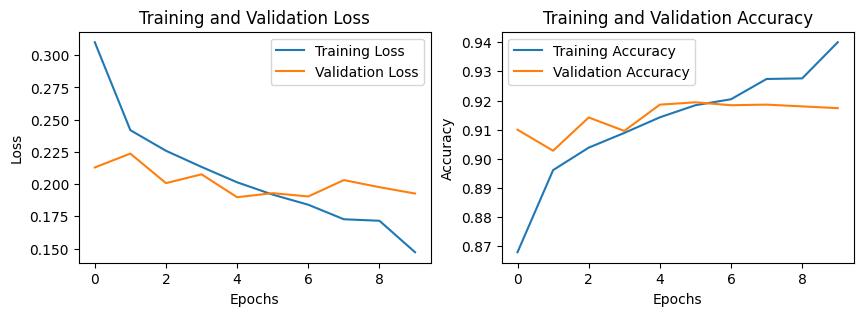

In [ ]:
import matplotlib.pyplot as plt

# Function to plot training history
def plot_training_history(history):
    fig, axs = plt.subplots(1, 2, figsize=(10, 3))

    # Plot training & validation loss
    axs[0].plot(history.history['loss'], label='Training Loss')
    axs[0].plot(history.history['val_loss'], label='Validation Loss')
    axs[0].set_title('Training and Validation Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    # Plot training & validation accuracy
    axs[1].plot(history.history['accuracy'], label='Training Accuracy')
    axs[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axs[1].set_title('Training and Validation Accuracy')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()

    plt.show()

# Call the function to plot the history
plot_training_history(history)

## MOdel EValuation **Accuracy**

In [ ]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(validation_generator, verbose=1) # Use validation_generator

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 71ms/step - accuracy: 0.9201 - loss: 0.1867
Test Accuracy: 91.86%
Test Loss: 0.1898


----------